In [2]:
import pandas as pd
import numpy as np
import yahoo_fin.stock_info as yh
from stock_clustering import clusters_dict
from stock_dataset import stock_data
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

Stock data ready to use!
Clustering done!


In [3]:
clusters_dict[2] = clusters_dict.pop(4)
clusters_dict.items()

dict_items([(3, ['AAPL', 'HD', 'MCD', 'MSFT', 'PG', 'WMT']), (1, ['AMGN', 'CVX', 'IBM', 'JNJ', 'KO', 'MRK', 'TRV', 'UNH']), (0, ['AXP', 'BA', 'CAT', 'CSCO', 'DOW', 'GS', 'HON', 'JPM', 'V']), (2, ['CRM', 'NKE'])])

Teraz co ja chcę z tym zrobić?
- potrzebuję utworzyć osobne słowniki dfów dla każdego klastra - **ZROBIONE**
- ekperymentalnie, na jednym ze słowników zrobić dwa modele - dla close i dla daily change:
    - najpierw zmienić dane na windowed df dla lstm'a (długość? trzy ostatnie dni starczą chyba); **ZROBIONE**
    - rozdzielić na train val test **ZROBIONE**
    - zbudować model dla close i model dla dailychange
    - porównać modele pod kątem sprawdzania się dla różnych firm
    - jeśli źle, przemyśleć klastryzację
    - jeśli w miarę dobrze, wybrać na czym opieramy model (close czy dailychange)
- stworzyć modele dla wszystkich klastrów
- ocenić ich jakość
- zapisać modele
- sprawdzić, jak je douczać

In [4]:
scaler = StandardScaler()

for key in stock_data:
    stock_data[key].set_index('date', inplace=True)
    stock_data[key][['close', 'dailychange']] = scaler.fit_transform(stock_data[key][['close', 'dailychange']])

In [5]:
stock_data['AAPL']

,close,dailychange
date,,
2020-07-20,-2.330226,-0.055511
2020-07-21,-2.396798,-0.756670
2020-07-22,-2.383435,0.087207
2020-07-23,-2.600561,-2.367859
2020-07-24,-2.611841,-0.181363
...,...,...
2023-07-12,2.152691,0.400977
2023-07-13,2.190452,0.150619
2023-07-14,2.197808,-0.015515


In [6]:
cluster_data = {}
for cluster, firm_names in clusters_dict.items():
    cluster_data[cluster] = {firm_name: stock_data[firm_name] for firm_name in firm_names}

In [7]:
cluster_0 = {}
for firm_name, df in cluster_data[0].items():
    cluster_0[firm_name] = df
    
cluster_1 = {}
for firm_name, df in cluster_data[1].items():
    cluster_1[firm_name] = df
    
cluster_2 = {}
for firm_name, df in cluster_data[2].items():
    cluster_2[firm_name] = df

cluster_3 = {}
for firm_name, df in cluster_data[3].items():
    cluster_3[firm_name] = df

In [8]:
cluster_0['CSCO']

,close,dailychange
date,,
2020-07-20,-0.391614,-0.015302
2020-07-21,-0.382927,0.053929
2020-07-22,-0.403776,-0.181280
2020-07-23,-0.315167,0.691916
2020-07-24,-0.490648,-1.400806
...,...,...
2023-07-12,0.263399,-1.737293
2023-07-13,0.400657,0.997285
2023-07-14,0.200852,-1.466725


In [10]:
closing = {}
for key in cluster_0.keys():
    closing[key] = cluster_0[key]['close']

In [59]:
closing['CSCO']

date
2020-07-20   -0.391614
2020-07-21   -0.382927
2020-07-22   -0.403776
2020-07-23   -0.315167
2020-07-24   -0.490648
                ...   
2023-07-12    0.263399
2023-07-13    0.400657
2023-07-14    0.200852
2023-07-17    0.275561
2023-07-18    0.350271
Name: close, Length: 754, dtype: float64

In [11]:
daily_change = {}
for key in cluster_0.keys():
    daily_change[key] = cluster_0[key]['dailychange']

In [62]:
def window_data(data, n):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data.shift(i)
    windowed_data['Target'] = data
    return windowed_data.dropna()

In [63]:
windowed_data = {}

for key, df in closing.items():
    windowed_data[key] = window_data(df, 4)

In [64]:
windowed_data['CSCO']

,Target-4,Target-3,Target-2,Target-1,Target
date,,,,,
2020-07-24,-0.391614,-0.382927,-0.403776,-0.315167,-0.490648
2020-07-27,-0.382927,-0.403776,-0.315167,-0.490648,-0.353391
2020-07-28,-0.403776,-0.315167,-0.490648,-0.353391,-0.511498
2020-07-29,-0.315167,-0.490648,-0.353391,-0.511498,-0.436788
2020-07-30,-0.490648,-0.353391,-0.511498,-0.436788,-0.483699
...,...,...,...,...,...
2023-07-12,0.327684,0.306835,0.378070,0.503165,0.263399
2023-07-13,0.306835,0.378070,0.503165,0.263399,0.400657
2023-07-14,0.378070,0.503165,0.263399,0.400657,0.200852


In [66]:
X = {}
Y = {}

for key, df in windowed_data.items():
    Y[key] = df.pop('Target')
    X[key] = df

In [67]:
q_80 = int(len(X['CSCO']) * .8)
q_99 = int(len(X['CSCO']) * .99)

X_train, X_val, X_test = {}, {}, {}
Y_train, Y_val, Y_test = {}, {}, {}

for key in X.keys():
    X_train[key], X_val[key], X_test[key] = X[key][:q_80], X[key][q_80:q_99], X[key][q_99:]

for key in Y.keys():
    Y_train[key], Y_val[key], Y_test[key] = Y[key][:q_80], Y[key][q_80:q_99], Y[key][q_99:]                                                


In [34]:
X = np.reshape(X, (X.shape[0], X_train.shape[1], 1))

AttributeError: 'dict' object has no attribute 'shape'

In [68]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [69]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(4,1)))
model.add(Dense(25))
model.add(Dense(1))

In [70]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11701 (45.71 KB)
Trainable params: 11701 (45.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
for key in X.keys():
    model.fit(X_train[key], Y_train[key], epochs=10, batch_size=10)

Epoch 1/10
60/60 [==============================] - 0s 1ms/step - loss: 0.3835
Epoch 2/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0281
Epoch 3/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 4/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 5/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 6/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 7/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 8/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0195
Epoch 9/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0186
Epoch 10/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 1/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 2/10
60/60 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 3/10
60/60 [==============================] -

In [73]:
X['CSCO'].index

DatetimeIndex(['2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06',
               ...
               '2023-07-05', '2023-07-06', '2023-07-07', '2023-07-10',
               '2023-07-11', '2023-07-12', '2023-07-13', '2023-07-14',
               '2023-07-17', '2023-07-18'],
              dtype='datetime64[ns]', name='date', length=750, freq=None)

19/19 [==============================] - 0s 668us/step


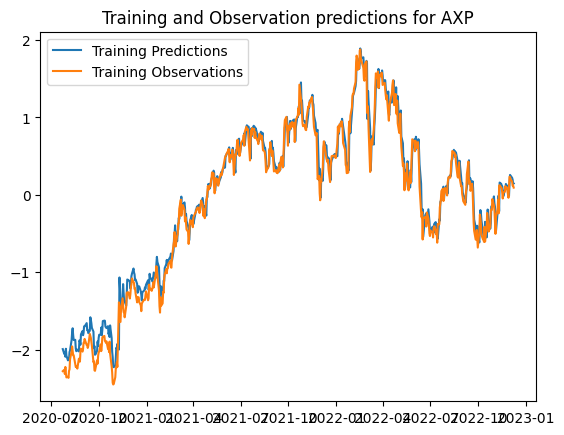

19/19 [==============================] - 0s 1ms/step


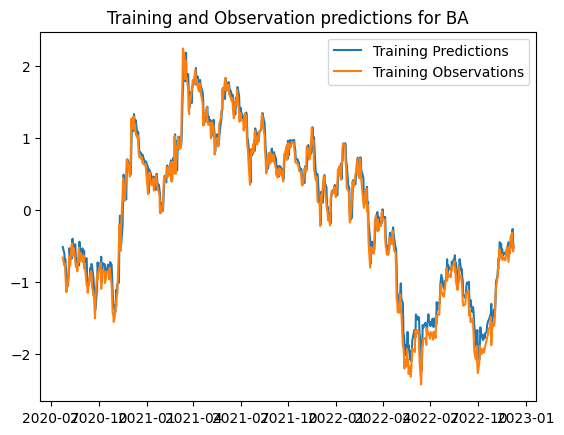

19/19 [==============================] - 0s 1ms/step


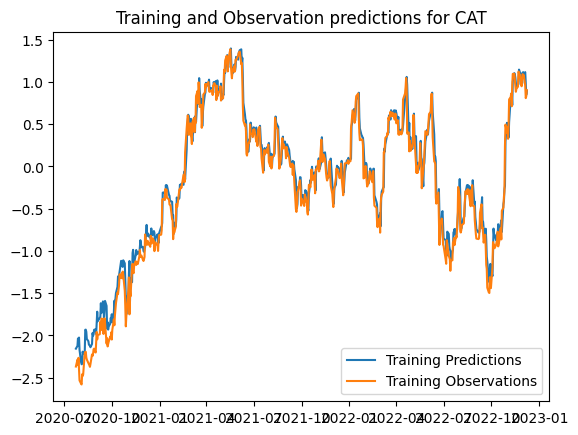

19/19 [==============================] - 0s 1ms/step


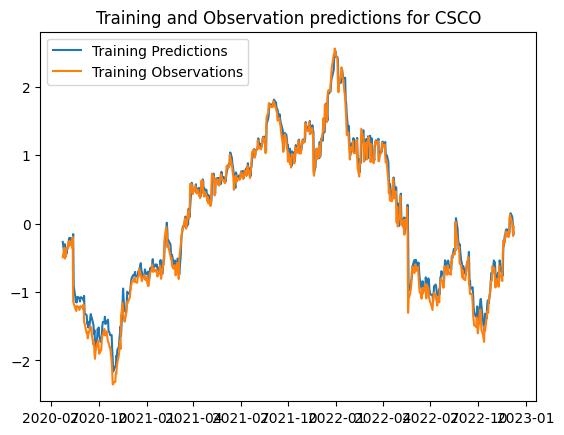

19/19 [==============================] - 0s 1ms/step


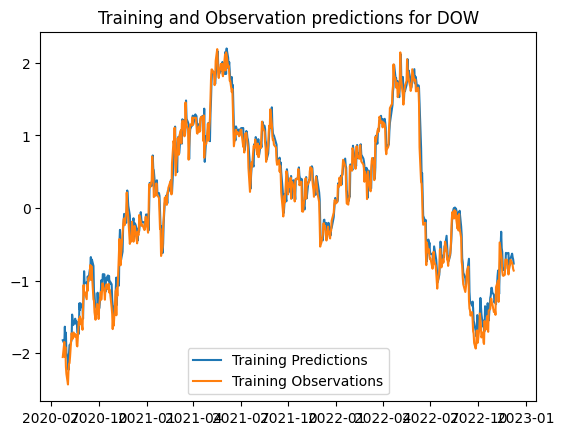

19/19 [==============================] - 0s 1ms/step


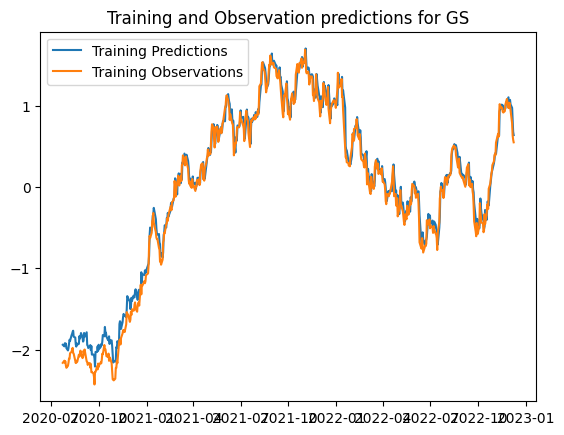

19/19 [==============================] - 0s 931us/step


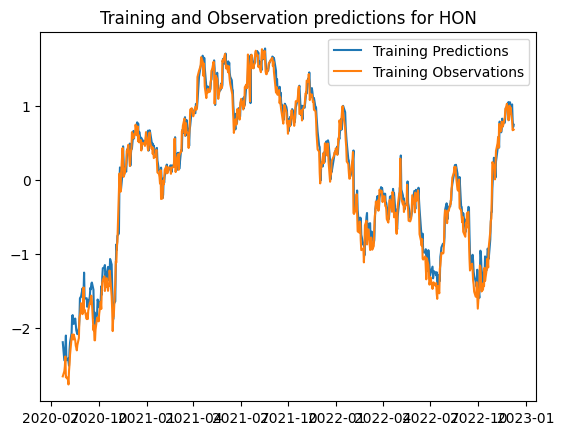

19/19 [==============================] - 0s 1ms/step


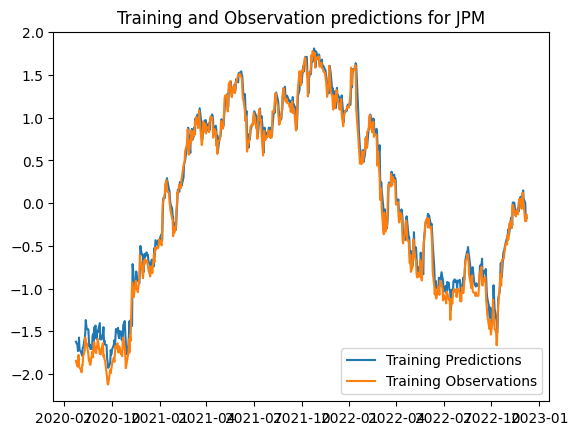

19/19 [==============================] - 0s 1ms/step


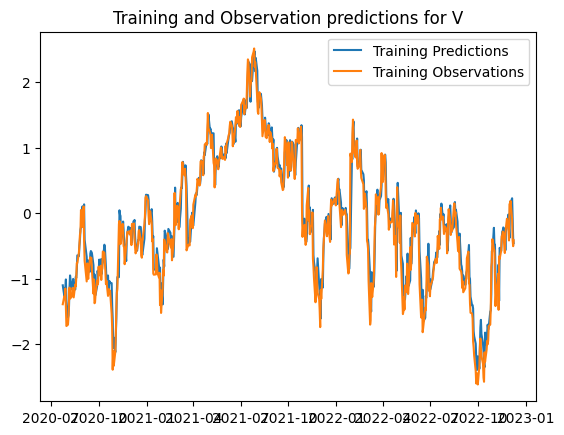

In [79]:
import matplotlib.pyplot as plt

for key in X.keys():
    train_predictions = model.predict(X_train[key]).flatten()
    plt.plot(X_train[key].index, train_predictions)
    plt.plot(X_train[key].index, Y_train[key])
    plt.legend(['Training Predictions', 'Training Observations'])
    plt.title(f'Training and Observation predictions for {key}')
    plt.show()